In [1]:
from typing import List, Dict, Any, Tuple, Optional, Self

import math, random, dataclasses, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.axes
from matplotlib.cm import get_cmap

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

# Structures de données et Visualisation

In [2]:
@dataclasses.dataclass
class Probleme:
    n: int  # Nombre de clients
    m: int  # Nombre de véhicules
    L: float  # Budget temps
    points: pd.DataFrame  # DataFrame des clients (x, y, score) => Pas une vraie donnée du problème TOP, mais utile pour afficher sur la carte
    # index du point de départ et du point d'arrivée (par défaut 0 et 1)
    start: int = 0
    end: int = 1
    # distance matrix stored as a numpy ndarray (shape n x n)
    dist_matrix: np.ndarray = dataclasses.field(init=False, repr=False)

    @classmethod
    def from_file(cls, filepath: str, start: int = 0, end: int = 1) -> Self:
        """Charge une instance à partir d'un fichier TSV attendu:\n première ligne: L <tab> m \n les lignes suivantes: x <tab> y <tab> score
        On peut passer `start` et `end` pour indiquer les indices des points de départ/arrivée dans les données.
        """
        metadata = pd.read_csv(filepath, sep=' ', nrows=3, header=None)
        points = pd.read_csv(filepath, sep='\t', skiprows=3, header=None)
        df = points.astype({0: float, 1: float, 2: int}).rename(columns={0: "x", 1: "y", 2: "score"})
        df = df.reset_index().rename(columns={'index': 'id'})
        return cls(
            n=df.shape[0],
            m=int(metadata.iloc[1, 1]),  # type: ignore
            L=float(metadata.iloc[2, 1]),  # type: ignore
            points=df,
            start=start,
            end=end,
        )

    def __post_init__(self):
        # compute Euclidean distances between points and store as numpy ndarray (shape n x n)
        pts = self.points[['x', 'y']].to_numpy()  # positional array, id == row index
        diffs = pts[:, None, :] - pts[None, :, :]
        mat = np.linalg.norm(diffs, axis=2)
        self.dist_matrix = mat  # numpy ndarray
        # Valider que start et end sont des indices valides [0, n-1]
        if not (0 <= self.start < self.n) or not (0 <= self.end < self.n):
            raise ValueError(f"Start ({self.start}) et End ({self.end}) doivent être des indices valides entre 0 et n-1")

    def scores_dict(self) -> Dict[int, int]:
        """Retourne un dict id -> score (utilise la colonne 'id' pour correspondre aux entiers)."""
        ids = self.ids()
        scores = self.points['score'].astype(int).tolist()
        return dict(zip(ids, scores))

    def ids(self) -> List[int]:
        return list(range(self.n))

    def plot(self, ax=None, title: Optional[str] = None) -> matplotlib.axes.Axes:
        """Affiche les points du problème sur `ax` (ou crée une figure).\n"""
        if ax is None:
            fig, ax = plt.subplots()
        pts = self.points
        ax.scatter(pts['x'], pts['y'], c='tab:blue', s=40, label='clients')
        # Annotate id and score next to chaque point
        for _, row in pts.iterrows():
            ax.text(row['x'] + 0.02, row['y'] + 0.02, f'id={int(row['id'])}, s={int(row['score'])}', fontsize=9)
        ax.set_title(title if title is not None else 'Instance')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend(loc='best')
        return ax


@dataclasses.dataclass
class Route:
    """Représente un cycle visitant une liste de points dans un problème donné et se connectant (implicitement) au point de départ à la fin."""
    stops: List[int]  # Indices (id column) des points visités en ordre
    probleme: Probleme  # Référence au problème associé pour calculer les métriques
    total_distance: float = 0.0
    total_score: int = 0

    def __post_init__(self):
        self.compute_totals()
        
    def __copy__(self) -> "Route":
        new = object.__new__(Route)  # Avoid recomputing totals
        new.stops = list(self.stops)
        new.probleme = self.probleme
        # preserve the already-computed totals without recomputing
        new.total_distance = self.total_distance
        new.total_score = self.total_score
        return new

    def compute_totals(self) -> None:
        """Calcule la distance du parcours (cycle) et le score cumulé des visites de noeuds."""
        # Use positional numpy arrays for coordinates and scores (ids are row indices)
        pts_arr = self.probleme.points[['x', 'y', 'score']].to_numpy()
        # Cas où il n'y a aucun arrêt
        if not self.stops:
            self.total_distance = 0.0
            self.total_score = 0
            return
        # Calculer les coordonnées des arrêts dans l'ordre (positional indexing)
        coords = pts_arr[self.stops, :2]
        # distances entre arrêts consécutifs
        dists = np.linalg.norm(coords[1:] - coords[:-1], axis=1) if len(coords) > 1 else np.array([], dtype=float)
        total = float(dists.sum())
        # Ajouter la distance de retour au point de départ pour former un cycle (TOP exige un retour)
        if len(coords) > 1:
            total += float(np.linalg.norm(coords[0] - coords[-1]))
        self.total_distance = total
        # score cumulé des arrêts
        self.total_score = int(pts_arr[self.stops, 2].sum())

    def __add__(self, other: int) -> 'Route':
        """Retourne une NOUVELLE Route avec `other` ajouté à la fin."""
        if other in self.stops:
            raise ValueError("Stop already in route")
        new_stops = list(self.stops) + [other]
        return Route(new_stops, self.probleme)

    def __remove__(self, other: int) -> 'Route':
        """Retourne une NOUVELLE Route sans l'arrêt `other`."""
        if other not in self.stops:
            raise ValueError("Stop not in route")
        new_stops = [s for s in self.stops if s != other]
        return Route(new_stops, self.probleme)

    def plot(self, ax=None, color='tab:orange', label: Optional[str] = None) -> matplotlib.axes.Axes:
        """Dessine la route sur `ax` (crée `ax` si None)."""
        if ax is None:
            fig, ax = plt.subplots()
        if not self.stops:
            return ax
        coords = self.probleme.points[['x', 'y']].to_numpy()[self.stops]
        # pour tracer le cycle, ajouter le premier point à la fin
        if len(coords) > 1:
            closed = np.vstack([coords, coords[0]])
        else:
            closed = coords
        # plot polyline (cycle)
        ax.plot(closed[:, 0], closed[:, 1], '-o', c=color, lw=2, label=(label if label else 'route'))
        # annotate stops with order
        for idx, sid in enumerate(self.stops):
            row = self.probleme.points.iloc[sid]
            ax.text(row['x'] + 0.02, row['y'] + 0.02, str(idx), color=color, fontsize=9)  # type: ignore : types de colonnes pandas non vérifiés
        return ax

# Recherche d'une solution initiale

In [3]:
def simple_greedy_routes(prob: Probleme, seed: Optional[int] = None, snapshot_every: int = 0) -> Tuple[List[Route], List[List[Route]]]:
    """Construction gloutonne (insertion séquentielle) adaptée au TOP.
    Les routes sont initialisées comme [start, end] et on insère des clients entre des paires
    consécutives (pos, pos+1). On utilise `prob.dist_matrix` (numpy) pour calculer delta de coût.
    Retourne (routes, snapshots).
    """
    # ids is a simple numeric range; do not rely on pandas index labels
    ids = prob.ids()
    scores = prob.scores_dict()
    # On ne sert pas start/end
    unserved = set(ids) - {prob.start, prob.end}
    routes: List[Route] = [Route([prob.start, prob.end], prob) for _ in range(prob.m)]
    snapshots: List[List[Route]] = []
    inserted = 0

    # insertion: pour chaque route, pour chaque position entre stops[pos] and stops[pos+1],
    # calculer delta = dist(i,u) + dist(u,j) - dist(i,j) using numpy dist_matrix
    while True:
        best = None  # tuple (ratio, r_idx, pos, u, delta)
        for r_idx, r in enumerate(routes):
            for pos in range(len(r.stops) - 1):
                i = r.stops[pos]
                j = r.stops[pos + 1]
                for u in list(unserved):
                    dlt = float(prob.dist_matrix[i, u] + prob.dist_matrix[u, j] - prob.dist_matrix[i, j])
                    new_cost = r.total_distance + dlt
                    if new_cost <= prob.L + 1e-9:
                        ratio = scores[u] / (dlt if dlt > 1e-9 else 1e-9)
                        if best is None or ratio > best[0]:
                            best = (ratio, r_idx, pos, u, dlt)
        if best is None:
            break
        _, r_idx, pos, u, dlt = best
        # perform insertion
        new_stops = list(routes[r_idx].stops)
        new_stops.insert(pos + 1, u)
        routes[r_idx] = Route(new_stops, prob)
        unserved.remove(u)
        inserted += 1
        if snapshot_every and (inserted % snapshot_every == 0):
            snapshots.append(routes.copy())
            
    return routes, snapshots

def polar_sweep_routes(prob: Probleme, max_routes: Optional[int] = None) -> List[Route]:
    """Heuristique 'Gillet & Miller' (balayage angulaire).
    - Classe les clients par angle polaire autour du dépôt (start).
    - Balaye l'angle et constitue des routes séquentielles en insérant le plus proche possible
      tant que la contrainte de longueur prob.L n'est pas violée.
    Justification : exploite la structure géométrique locale (bon pour dépôts centraux)."""
    if max_routes is None:
        max_routes = prob.m
    start_xy = prob.points.loc[prob.start, ['x', 'y']].to_numpy()
    ids = [i for i in prob.ids() if i not in (prob.start, prob.end)]
    # compute angles
    pts = prob.points[['x', 'y']].to_numpy()
    rel = pts[ids] - start_xy[None, :]
    angles = np.arctan2(rel[:,1], rel[:,0])
    order = [ids[i] for i in np.argsort(angles)]

    routes: List[Route] = []
    current = Route([prob.start, prob.end], prob)
    for u in order:
        # try cheapest insertion into current route
        best_pos = None
        best_dlt = None
        for pos in range(len(current.stops)-1):
            i = current.stops[pos]; j = current.stops[pos+1]
            dlt = float(prob.dist_matrix[i,u] + prob.dist_matrix[u,j] - prob.dist_matrix[i,j])
            if current.total_distance + dlt <= prob.L + 1e-9:
                if best_pos is None or dlt < best_dlt:
                    best_pos = pos; best_dlt = dlt
        if best_pos is not None:
            new_stops = list(current.stops); new_stops.insert(best_pos+1, u)
            current = Route(new_stops, prob)
        else:
            # close current route and start a new one if allowed
            routes.append(current)
            if len(routes) >= max_routes:
                # remaining clients are left unserved
                current = Route([prob.start, prob.end], prob)
                break
            current = Route([prob.start, prob.end], prob)
            # try insert u into fresh route (if fits)
            i = current.stops[0]; j = current.stops[1]
            dlt = float(prob.dist_matrix[i,u] + prob.dist_matrix[u,j] - prob.dist_matrix[i,j])
            if dlt + current.total_distance <= prob.L + 1e-9:
                current = Route([prob.start, u, prob.end], prob)
    routes.append(current)
    # pad with empty routes if needed
    while len(routes) < prob.m:
        routes.append(Route([prob.start, prob.end], prob))
    return routes

def clarke_wright_marguerite(prob: Probleme, limit_routes: Optional[int] = None) -> List[Route]:
    """Heuristique de Clarke & Wright (marguerite) - version simple.
    - Initialise une route par client: [start, u, end].
    - Calcule les 'savings' s(u,v) = d(s,u)+d(v,s)-d(u,v) et les trie décroissants.
    - Tente de fusionner deux routes quand les extrémités sont compatibles et que la fusion
      respecte la limite de longueur prob.L.
    Justification : méthode parallèle classique, minimise coût et nombre de routes."""
    if limit_routes is None:
        limit_routes = prob.m
    ids = [i for i in prob.ids() if i not in (prob.start, prob.end)]
    # start with one-route-per-client
    routes = {u: Route([prob.start, u, prob.end], prob) for u in ids}
    # compute savings
    savings = []
    for i_idx, u in enumerate(ids):
        for v in ids[i_idx+1:]:
            s = float(prob.dist_matrix[prob.start, u] + prob.dist_matrix[v, prob.start] - prob.dist_matrix[u, v])
            savings.append((s, u, v))
    savings.sort(reverse=True, key=lambda x: x[0])

    for s, u, v in savings:
        # check routes still exist and are distinct
        if u not in routes or v not in routes or u == v:
            continue
        ru = routes[u]; rv = routes[v]
        if ru is rv:
            continue
        # ru: ... u ] , rv: [ v ... => try to connect tail of ru to head of rv
        if ru.stops[-2] == u and rv.stops[1] == v:
            candidate_stops = ru.stops[:-1] + rv.stops[1:]
            cand = Route(candidate_stops, prob)
            if cand.total_distance <= prob.L + 1e-9:
                # merge: remove all keys pointing to ru and rv and add new representative
                # use first client in merged route as key
                merged_clients = [x for x in cand.stops if x not in (prob.start, prob.end)]
                # remove old entries
                for x in list(routes.keys()):
                    if routes[x] is ru or routes[x] is rv:
                        del routes[x]
                # register merged route under its clients
                for x in merged_clients:
                    routes[x] = cand
        # stop early if enough routes
        unique_routes = {id(r) : r for r in routes.values()}.values()
        if len(list(unique_routes)) <= limit_routes:
            break
    # return up to prob.m routes (unique objects)
    uniq = list({id(r): r for r in routes.values()}.values())
    # pad
    while len(uniq) < prob.m:
        uniq.append(Route([prob.start, prob.end], prob))
    return uniq[:prob.m]

import random
def randomized_greedy_routes(prob: Probleme, alpha: float = 0.2, seed: Optional[int] = None) -> List[Route]:
    """Variante GRASP-like de construction : à chaque insertion, on crée une RCL (restricted candidate list)
    composée des meilleurs k candidats (selon score/delta) et on choisit aléatoirement dedans.
    Justification : introduit diversité utile pour méta-heuristiques et pools d'initiation."""
    if seed is not None:
        random.seed(seed)
    ids = prob.ids()
    scores = prob.scores_dict()
    unserved = set(ids) - {prob.start, prob.end}
    routes: List[Route] = [Route([prob.start, prob.end], prob) for _ in range(prob.m)]
    while True:
        candidates = []  # (score_ratio, r_idx, pos, u, dlt)
        for r_idx, r in enumerate(routes):
            for pos in range(len(r.stops)-1):
                i = r.stops[pos]; j = r.stops[pos+1]
                for u in unserved:
                    dlt = float(prob.dist_matrix[i,u] + prob.dist_matrix[u,j] - prob.dist_matrix[i,j])
                    if r.total_distance + dlt <= prob.L + 1e-9:
                        ratio = scores[u] / (dlt if dlt > 1e-9 else 1e-9)
                        candidates.append((ratio, r_idx, pos, u, dlt))
        if not candidates:
            break
        candidates.sort(reverse=True, key=lambda x: x[0])
        k = max(1, int(len(candidates) * alpha))
        chosen = random.choice(candidates[:k])
        _, r_idx, pos, u, dlt = chosen
        new_stops = list(routes[r_idx].stops); new_stops.insert(pos+1, u)
        routes[r_idx] = Route(new_stops, prob)
        unserved.remove(u)
    return routes

# Amélioration d'une solution (rechrche locale)

In [4]:
def two_opt_route(route: Route, max_iter: int = 1000) -> Route:
    """Amélioration locale 2-opt sur une Route (retourne une NOUVELLE Route améliorée).
    On respecte la contrainte de longueur `route.probleme.L`: toute modification doit garder total_distance <= prob.L.
    Les extrémités (start / end) sont conservées.
    """
    best = Route(list(route.stops), route.probleme)
    n = len(best.stops)
    if n < 4:  # moins de 2 arêtes internes -> rien à inverser
        return best
    improved = True
    it = 0
    while improved and it < max_iter:
        improved = False
        it += 1
        for i in range(1, n - 2):  # ne pas toucher l'indice 0 (start)
            for j in range(i + 1, n - 1):  # ne pas toucher l'indice n-1 (end)
                # créer une nouvelle permutation en inversant le segment i..j
                new_stops = best.stops[:i] + list(reversed(best.stops[i:j+1])) + best.stops[j+1:]
                candidate = Route(new_stops, route.probleme)
                # accepter si amélioration (réduction de distance) et toujours faisable
                if candidate.total_distance + 1e-9 < best.total_distance and candidate.total_distance <= route.probleme.L + 1e-9:
                    best = candidate
                    improved = True
                    break
            if improved:
                break
    return best

def two_opt_each_routes(routes: List[Route], max_iter: int = 1000) -> List[Route]:
    """Applique 2-opt localement sur chaque route de la liste `routes`.
    Retourne une NOUVELLE liste de routes améliorées."""
    new_routes = []
    for r in routes:
        improved_route = two_opt_route(r, max_iter=max_iter)
        new_routes.append(improved_route)
    return new_routes

def swap_between_routes(routes: List[Route], prob: Probleme) -> List[Route]:
    """Swap simple entre routes : échange de deux noeuds (excluant start/end) appartenant à deux routes.
    - Parcourt toutes les paires (r1,r2) et tous les clients i in r1, j in r2 et teste l'échange.
    - Accepte l'échange qui augmente la somme des scores et respecte prob.L pour les deux routes.
    Justification : opérateur basique (Swap) pour VRP/TOP; explore voisinage inter-routes."""
    best_gain = 0
    best_move = None  # (r1_idx, i_pos, r2_idx, j_pos, new_r1, new_r2)
    for a in range(len(routes)):
        for b in range(a+1, len(routes)):
            r1 = routes[a]; r2 = routes[b]
            for i_pos in range(1, len(r1.stops)-1):
                for j_pos in range(1, len(r2.stops)-1):
                    i = r1.stops[i_pos]; j = r2.stops[j_pos]
                    new_r1_stops = list(r1.stops); new_r1_stops[i_pos] = j
                    new_r2_stops = list(r2.stops); new_r2_stops[j_pos] = i
                    cand1 = Route(new_r1_stops, prob); cand2 = Route(new_r2_stops, prob)
                    if cand1.total_distance <= prob.L + 1e-9 and cand2.total_distance <= prob.L + 1e-9:
                        gain = (cand1.total_score + cand2.total_score) - (r1.total_score + r2.total_score)
                        if gain > best_gain + 1e-9:
                            best_gain = gain
                            best_move = (a, i_pos, b, j_pos, cand1, cand2)
    if best_move is not None:
        a, i_pos, b, j_pos, cand1, cand2 = best_move
        routes[a] = cand1; routes[b] = cand2
    return routes

def or_opt_between_routes(routes: List[Route], prob: Probleme, k: int = 2) -> List[Route]:
    """Or-Opt inter-routes : extrait une chaîne de longueur k d'une route et tente de l'insérer
    telle quelle dans une autre route (toutes positions). On accepte si la somme des scores augmente
    et si les deux routes restent faisables (<= prob.L)."""
    best_gain = 0; best_move = None
    for a in range(len(routes)):
        for b in range(len(routes)):
            if a == b: continue
            rA = routes[a]; rB = routes[b]
            for i in range(1, max(1, len(rA.stops)-k)):
                segment = rA.stops[i:i+k]
                if len(segment) < k: continue
                # new A without segment
                newA = rA.stops[:i] + rA.stops[i+k:]
                for pos in range(1, len(rB.stops)):
                    newB = list(rB.stops[:pos]) + segment + list(rB.stops[pos:])
                    candA = Route(newA, prob); candB = Route(newB, prob)
                    if candA.total_distance <= prob.L + 1e-9 and candB.total_distance <= prob.L + 1e-9:
                        gain = (candA.total_score + candB.total_score) - (rA.total_score + rB.total_score)
                        if gain > best_gain + 1e-9:
                            best_gain = gain; best_move = (a, b, i, k, pos, candA, candB)
    if best_move is not None:
        a, b, i, k, pos, candA, candB = best_move
        routes[a] = candA; routes[b] = candB
    return routes

def cross_exchange(routes: List[Route], prob: Probleme) -> List[Route]:
    """Cross-exchange simple : échange deux suffixes (ou préfixes) entre deux routes.
    - Pour chaque paire de routes, teste échange de segments r1[i:] <-> r2[j:], vérifie faisabilité
      et accepte si le score total augmente.
    Justification : opérateur de 'string exchange' simplifié pour diversification."""
    best_gain = 0; best_move = None
    for a in range(len(routes)):
        for b in range(a+1, len(routes)):
            r1 = routes[a]; r2 = routes[b]
            for i in range(1, len(r1.stops)-1):
                for j in range(1, len(r2.stops)-1):
                    new1 = r1.stops[:i] + r2.stops[j:]
                    new2 = r2.stops[:j] + r1.stops[i:]
                    cand1 = Route(new1, prob); cand2 = Route(new2, prob)
                    if cand1.total_distance <= prob.L + 1e-9 and cand2.total_distance <= prob.L + 1e-9:
                        gain = (cand1.total_score + cand2.total_score) - (r1.total_score + r2.total_score)
                        if gain > best_gain + 1e-9:
                            best_gain = gain; best_move = (a, b, cand1, cand2)
    if best_move is not None:
        a, b, cand1, cand2 = best_move
        routes[a] = cand1; routes[b] = cand2
    return routes

# Tests

In [5]:
import time
class Lap():
    def __init__(self):
        self.current_time = time.time()
    def lap(self) -> float:
        lap_time = time.time() - self.current_time
        self.current_time = time.time()
        return lap_time

filepath = 'data/p1.4.c.txt'
prob = Probleme.from_file(filepath)
print(f"Problème chargé: n={prob.n}, m={prob.m}, L={prob.L}")

Problème chargé: n=32, m=4, L=25.5


In [6]:
lap = Lap()

routes, snapshots = simple_greedy_routes(prob, snapshot_every=5)
print(f"Routes construites: {len(routes)} / temps écoulé: {lap.lap():.4f}s")

for r_idx, r in enumerate(routes):
    improved = two_opt_route(r, max_iter=500)
    routes[r_idx] = improved
print(f"Routes améliorées avec 2-opt / temps écoulé: {lap.lap():.4f}s")

print(f"Score final des routes: {[r.total_score for r in routes]} = {sum(r.total_score for r in routes)}")
print(f"Répartition des distances: {[r.total_distance for r in routes]} = {sum(r.total_distance for r in routes)} / budget max: {prob.L * prob.m} = {prob.L} x {prob.m}")

Routes construites: 4 / temps écoulé: 0.0161s
Routes améliorées avec 2-opt / temps écoulé: 0.0191s
Score final des routes: [25, 55, 50, 55] = 185
Répartition des distances: [24.014169281249572, 24.805573878895835, 24.127260423582854, 25.4213699056482] = 98.36837348937647 / budget max: 102.0 = 25.5 x 4


In [7]:
lap = Lap()

# routes, snapshots = simple_greedy_routes(prob, snapshot_every=5)
routes, snapshots = randomized_greedy_routes(prob, alpha=0.3, seed=42), []
print(f"Routes construites: {len(routes)} / temps écoulé: {lap.lap():.4f}s")

routes = two_opt_each_routes(routes, max_iter=500)
routes = swap_between_routes(routes, prob)
routes = or_opt_between_routes(routes, prob, k=2)
routes = cross_exchange(routes, prob)
print(f"Routes améliorées avec 2-opt et + / temps écoulé: {lap.lap():.4f}s")

print(f"Score final des routes: {[r.total_score for r in routes]} = {sum(r.total_score for r in routes)}")
print(f"Répartition des distances: {[r.total_distance for r in routes]} = {sum(r.total_distance for r in routes)} / budget max: {prob.L * prob.m} = {prob.L} x {prob.m}")

Routes construites: 4 / temps écoulé: 0.0156s
Routes améliorées avec 2-opt et + / temps écoulé: 0.4318s
Score final des routes: [65, 35, 30, 45] = 175
Répartition des distances: [24.72228152560399, 25.00932859736993, 24.341294232826456, 22.611756204560095] = 96.68466056036047 / budget max: 102.0 = 25.5 x 4


# Recherche "Meta"

In [8]:
# TODO : Try combination of initialization + local search + inter-route operators

# Tests avec Plotting

Initial scores:  [20, 20, 10, 15, 10] = 75
Intermediate scores:  [20, 20, 10, 15, 10] = 75
Intermediate scores:  [20, 20, 10, 15, 10] = 75
Intermediate scores:  [20, 20, 10, 15, 10] = 75
Intermediate scores:  [20, 20, 10, 15, 10] = 75
seed = 469521477


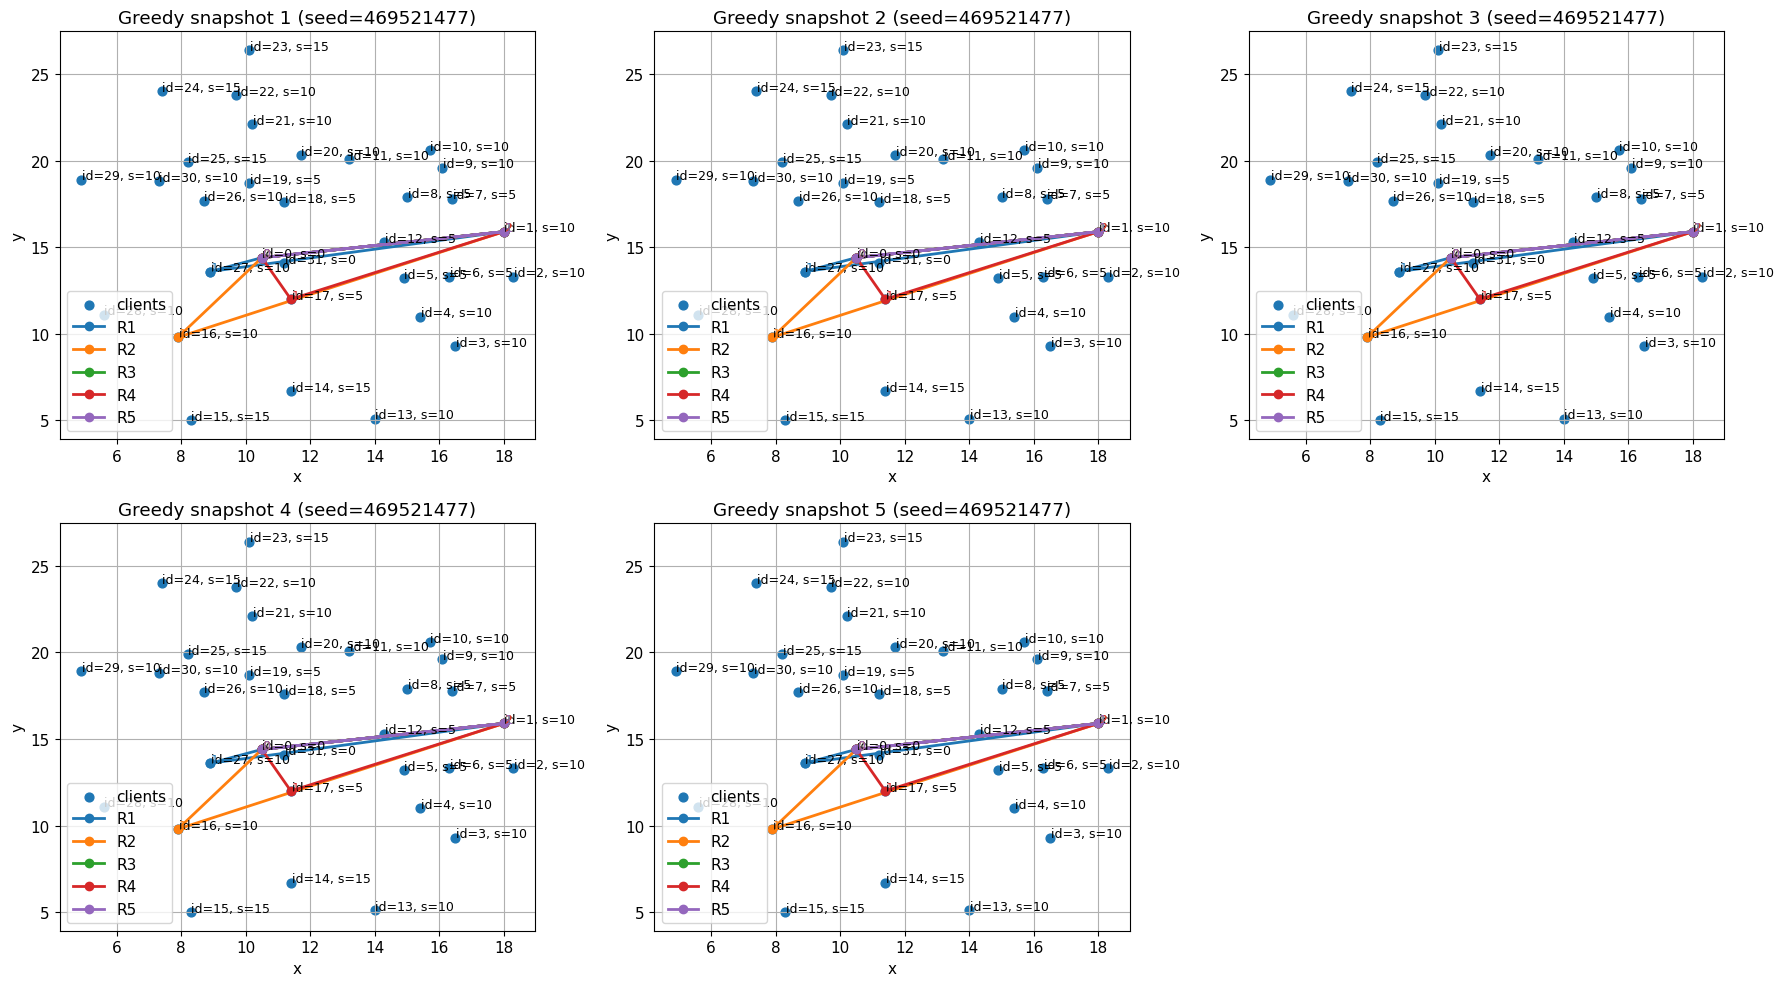

In [9]:
# dist_matrix est calculée automatiquement dans Probleme.__post_init__
seed = random.randrange(1 << 30)
# routes, snapshots = simple_greedy_routes(prob, seed=seed, snapshot_every=1)
# snapshots = [randomized_greedy_routes(prob, alpha=0.2, seed=seed)]
snapshots = [polar_sweep_routes(prob)]
routes = snapshots[-1]

print('Initial scores: ', [r.total_score for r in routes], '=', sum(r.total_score for r in routes))

# Après construction, appliquer les améliorations locales et inter-routes
for improvement in (
    lambda x: two_opt_each_routes(x, max_iter=500),
    lambda x: swap_between_routes(x, prob),
    lambda x: or_opt_between_routes(x, prob, k=2),
    lambda x: cross_exchange(x, prob),
):
    routes = improvement(routes)
    snapshots.append(routes.copy())
    print('Intermediate scores: ', [r.total_score for r in routes], '=', sum(r.total_score for r in routes))

print('seed =', seed)

# Plot snapshots in a 3 x N grid
cols = 3
n_snap = len(snapshots)
if n_snap > 0:
    rows = math.ceil(n_snap / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    # flatten axes array for easy indexing
    axs_flat = axs.flatten() if hasattr(axs, 'flatten') else [axs]
    for i, s in enumerate(snapshots):
        ax = axs_flat[i]
        prob.plot(ax=ax, title=f'Greedy snapshot {i+1} (seed={seed})')
        for j, r in enumerate(s):
            r.plot(ax=ax, color=f'C{j%10}', label=f'R{j+1}')
        ax.legend()
    # hide unused axes
    for k in range(n_snap, rows*cols):
        axs_flat[k].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No snapshots to display')